Current Problem
- Model predicts low losses with (e.g., DICE loss), but when using it to predict on either testing or training datasets, the output is a mask that's all zero 

In [1]:
# Import Libraries
import os
os.environ["KERAS_BACKEND"] = "tensorflow" 

import keras
import numpy as np
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
from keras import layers
import cv2 as cv

ModuleNotFoundError: No module named 'keras'

In [2]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Limiting GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    # keras.mixed_precision.set_global_policy("mixed_float16")
    # print("Using mixed_precision float16")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


I0000 00:00:1741217510.874714  153400 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13140 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
# Hyperparameters

image_dir = "cleaned_t1c/images"
mask_dir = "cleaned_t1c/masks"
image_size = (240, 240)
batch_size = 16

In [4]:
# Create lists of images for each partition

def sort_list(image_dir): 
    # Create function that will sort the partition list
    return sorted(
        [
            os.path.join(image_dir, fname)
            for fname in os.listdir(image_dir)
            if fname.endswith(".png")
        ]
        )

# Create the sorted list for the images partition
train_image = sort_list(os.path.join(image_dir, "train"))
val_image = sort_list(os.path.join(image_dir, "val"))
test_image = sort_list(os.path.join(image_dir, "test"))

# Create the sorted list for the masks partition
train_mask = sort_list(os.path.join(mask_dir, "train"))
val_mask = sort_list(os.path.join(mask_dir, "val"))
test_mask = sort_list(os.path.join(mask_dir, "test"))

print(f"\nThere is approximately {len(train_image)} images within the training set\n")

for input_path, target_path in zip(train_image[:10], train_mask[:10]):
    print(input_path, "|", target_path)



There is approximately 3095 images within the training set

cleaned_t1c/images/train/BraTS-PED-00002-00064-t1c.png | cleaned_t1c/masks/train/BraTS-PED-00002-00064-t1c.png
cleaned_t1c/images/train/BraTS-PED-00002-00065-t1c.png | cleaned_t1c/masks/train/BraTS-PED-00002-00065-t1c.png
cleaned_t1c/images/train/BraTS-PED-00002-00066-t1c.png | cleaned_t1c/masks/train/BraTS-PED-00002-00066-t1c.png
cleaned_t1c/images/train/BraTS-PED-00002-00067-t1c.png | cleaned_t1c/masks/train/BraTS-PED-00002-00067-t1c.png
cleaned_t1c/images/train/BraTS-PED-00002-00068-t1c.png | cleaned_t1c/masks/train/BraTS-PED-00002-00068-t1c.png
cleaned_t1c/images/train/BraTS-PED-00002-00069-t1c.png | cleaned_t1c/masks/train/BraTS-PED-00002-00069-t1c.png
cleaned_t1c/images/train/BraTS-PED-00002-00070-t1c.png | cleaned_t1c/masks/train/BraTS-PED-00002-00070-t1c.png
cleaned_t1c/images/train/BraTS-PED-00002-00071-t1c.png | cleaned_t1c/masks/train/BraTS-PED-00002-00071-t1c.png
cleaned_t1c/images/train/BraTS-PED-00002-00072-t1c.

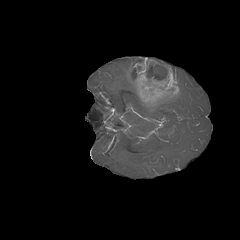

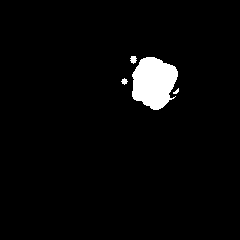

tf.Tensor([240 240   1], shape=(3,), dtype=int32)
tf.Tensor(
[0.         0.18431373 0.21960784 0.17254902 0.16078432 0.14117648
 0.18039216 0.23921569 0.24313726 0.27450982 0.25882354 0.2901961
 0.34901962 0.2784314  0.23137255 0.16470589 0.12941177 0.12156863
 0.21176471 0.28627452 0.33333334 0.3529412  0.39607844 0.43137255
 0.41960785 0.43529412 0.44705883 0.4117647  0.37254903 0.3647059
 0.36862746 0.38431373 0.41568628 0.40392157 0.42745098 0.54509807
 0.47843137 0.34509805 0.5647059  0.4392157  0.2627451  0.26666668
 0.1882353  0.27058825 0.3137255  0.34117648 0.35686275 0.36078432
 0.32941177 0.29411766 0.30588236 0.39215687 0.38039216 0.45882353
 0.4627451  0.47058824 0.7058824  0.8        0.6666667  0.3882353
 0.14901961 0.05098039 0.20392157 0.23529412 0.28235295 0.29803923
 0.30980393 0.3372549  0.32156864 0.3764706  0.4509804  0.64705884
 0.6509804  0.3254902  0.07058824 0.21568628 0.2509804  0.3019608
 0.44313726 0.48235294 0.49803922 0.5058824  0.49411765 0.46666667
 0.4 

In [ ]:
# Display the image to ensure it works correctly

from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=train_image[100]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(train_mask[100]))

display(img)

# img = cv.imread(train_image[100])
# mask = cv.imread(train_mask[100])
# print(np.unique(mask))
# print(np.unique(img))

# input_img = tf_io.read_file(train_image[100])
# input_img = tf_io.decode_png(input_img, channels=1)
# input_img = tf_image.resize(input_img, image_size)
# input_img = tf.cast(input_img, tf.float32) / 255.0

# print(tf.shape(input_img))
# print(tf.unique(tf.reshape(input_img, [-1])).y)

In [6]:
# Create the function that returns TF datasets by pairing the image and mask

def get_dataset(
    batch_size,
    image_size,
    image_paths,
    mask_paths,):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=1)
        input_img = tf_image.resize(input_img, image_size)
        input_img = tf.cast(input_img, tf.float32) / 255.0

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, image_size, method="nearest")
        target_img = tf.cast(target_img, tf.float32) / 255.0

        return input_img, target_img

    dataset = tf_data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)


In [7]:
def get_model(img_size, num_classes=1):
    inputs = keras.Input(shape=img_size + (1,))

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(96, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    model = keras.models.Model(inputs=[inputs], outputs=[outputs])

    return model

# Build model
model = get_model(image_size)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 240, 240,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 240, 240,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 120, 120,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 120, 120,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 120, 120,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 60, 60,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │     55,392 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 60, 60,    │     83,040 │ conv2d_4[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 30, 30,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 30, 30,    │    110,720 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 30, 30,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 15, 15,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 15, 15,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 15, 15,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 30, 30,    │    131,200 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 30, 30,    │          0 │ conv2d_transpose

 Total params: 2,390,401 (9.12 MB)

 Trainable params: 2,390,401 (9.12 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# # Define the function to create a unet

# def get_model(img_size):
#     inputs = keras.Input(shape=img_size + (1,))

#     ### [First half of the network: downsampling inputs] ###

#     # Entry block
#     x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     previous_block_activation = x  # Set aside residual

#     # Blocks 1, 2, 3 are identical apart from the feature depth.
#     for filters in [64, 128, 256]:
#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
        
#         x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     ### [Second half of the network: upsampling inputs] ###

#     for filters in [256, 128, 64, 32]:
#         x = layers.Activation("relu")(x)
#         x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.UpSampling2D(2)(x)

#         # Project residual
#         residual = layers.UpSampling2D(2)(previous_block_activation)
#         residual = layers.Conv2D(filters, 1, padding="same")(residual)
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     # Add a per-pixel classification layer
#     outputs = layers.Conv2D(1, 1, activation="sigmoid", padding="same")(x)

#     # Define the model
#     model = keras.Model(inputs, outputs)
#     return model


# # Build model
# model = get_model(image_size)
# model.summary()

In [9]:
# Create the train, val and test split with the pairings

train_dataset = get_dataset(
    batch_size,
    image_size,
    train_image,
    train_mask,)

val_dataset = get_dataset(
    batch_size, 
    image_size, 
    val_image, 
    val_mask, )

test_dataset = get_dataset(
    batch_size, 
    image_size, 
    test_image, 
    test_mask, )

for batch in train_dataset.take(1): 
    images, masks = batch
    print(images.shape)
    print(masks.shape)

for image in images: 
    print(np.unique(image))
    print(np.max(image))
    print(np.min(image))
    print(image.shape)

# # Check values in the first batch
# for input_img, target_img in train_dataset.take(10):
#     print("Information of image:\n", np.max(input_img), np.min(input_img), input_img.dtype)
#     print("Information of mask:\n", np.max(target_img), np.min(target_img), target_img.dtype, np.unique(target_img))

(16, 240, 240, 1)
(16, 240, 240, 1)
[0.         0.10588235 0.10980392 0.11372549 0.11764706 0.12156863
 0.1254902  0.12941177 0.13333334 0.13725491 0.14117648 0.14509805
 0.14901961 0.15294118 0.15686275 0.16078432 0.16470589 0.16862746
 0.17254902 0.1764706  0.18039216 0.18431373 0.1882353  0.19215687
 0.19607843 0.2        0.20392157 0.20784314 0.21176471 0.21568628
 0.21960784 0.22352941 0.22745098 0.23137255 0.23529412 0.23921569
 0.24313726 0.24705882 0.2509804  0.25490198 0.25882354 0.2627451
 0.26666668 0.27058825 0.27450982 0.2784314  0.28235295 0.28627452
 0.2901961  0.29411766 0.29803923 0.3019608  0.30588236 0.30980393
 0.3137255  0.31764707 0.32156864 0.3254902  0.32941177 0.33333334
 0.3372549  0.34117648 0.34509805 0.34901962 0.3529412  0.35686275
 0.36078432 0.3647059  0.36862746 0.37254903 0.3764706  0.38039216
 0.38431373 0.3882353  0.39215687 0.39607844 0.4        0.40392157
 0.40784314 0.4117647  0.41568628 0.41960785 0.42352942 0.42745098
 0.43137255 0.43529412 0.43

2025-03-05 18:31:56.769554: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def weighted_binary_crossentropy(beta=0.9):
    def loss(y_true, y_pred):
        weight_for_1 = beta
        weight_for_0 = 1 - beta
        
        y_true = tf.cast(y_true, tf.float32)
        
        loss = -(weight_for_1 * y_true * tf.math.log(y_pred + 1e-7) +
                 weight_for_0 * (1 - y_true) * tf.math.log(1 - y_pred + 1e-7))
        
        return tf.reduce_mean(loss)
    return loss

In [11]:
# loss_fn = dice_loss if loss_type == 'dice' else weighted_binary_crossentropy(beta=0.9)

class_weights = {0: 1.0, 1: 10.0}

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), 
    loss=dice_loss, 
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True),
    keras.callbacks.CSVLogger(filename="cvslog.csv", separator=",", append=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 5
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=2,
)

Epoch 1/5


/home/research/miniconda3/envs/unet/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 240, 240, 1))
  warnings.warn(msg)
I0000 00:00:1741217520.818243  153479 service.cc:148] XLA service 0x7ea95800e590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741217520.818271  153479 service.cc:156]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-03-05 18:32:00.930551: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741217521.314652  153479 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1741217533.556822  153479 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-03

194/194 - 46s - 237ms/step - loss: 1.1588 - val_loss: 1.0000
Epoch 2/5
194/194 - 20s - 102ms/step - loss: 1.1916 - val_loss: 1.0000
Epoch 3/5
194/194 - 20s - 103ms/step - loss: 1.1916 - val_loss: 1.0000
Epoch 4/5
194/194 - 20s - 103ms/step - loss: 1.1916 - val_loss: 1.0000
Epoch 5/5
194/194 - 20s - 103ms/step - loss: 1.1916 - val_loss: 1.0000


/home/research/miniconda3/envs/unet/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(16, 240, 240, 1))
  warnings.warn(msg)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


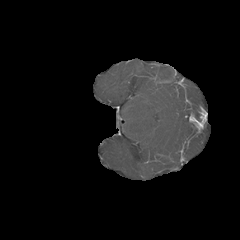

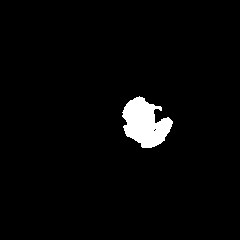

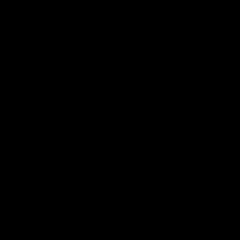

In [12]:
# Generate predictions for all images in the validation set
import cv2 as cv

test_prediction = model.predict(test_dataset)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_prediction[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)
    cv.imwrite("mask.png", mask)

# Display results for validation image #10
i = 50

# Display input image
display(Image(filename=test_image[i])) # test_image is a list
img = cv.imread(test_image[i])
cv.imwrite("original.png", img)

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(test_mask[i])) # test_mask is also a list
display(img)
img = cv.imread(test_mask[i])
cv.imwrite("ground_truth.png", img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.


In [13]:
# obtain the predictions
train_prediction = model.predict(train_dataset)

/home/research/miniconda3/envs/unet/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(16, 240, 240, 1))
  warnings.warn(msg)


193/194 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/home/research/miniconda3/envs/unet/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 240, 240, 1))
  warnings.warn(msg)


194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step


In [15]:
from sklearn.metrics import confusion_matrix

#Predict
y_prediction = model.predict(train_prediction)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(train_dataset, y_prediction , normalize='pred')

97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step


ValueError: Found input variables with inconsistent numbers of samples: [194, 3095]

In [ ]:
# Generate predictions for all images in the validation set
import cv2 as cv

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(train_prediction[i], axis=-1) 
    # print(np.unique(mask))
    # print(mask.shape)
    mask = np.expand_dims(mask, axis=-1)
    mask = mask * (255 // (np.max(mask) + 1))  # Normalize the mask to [0, 255]
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)
    cv.imwrite("mask.png", mask)

# Display results for training image
i = 99

# # Display input image
# display(Image(filename=train_image[i])) 
# img = cv.imread(train_image[i])
# cv.imwrite("original.png", img)

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(train_mask[i])) # test_mask is also a list
display(img)
img = cv.imread(train_mask[i])
cv.imwrite("ground_truth.png", img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.


/home/research/miniconda3/envs/unet/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 240, 240, 1))
  warnings.warn(msg)


97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step


ValueError: Found input variables with inconsistent numbers of samples: [194, 3095]

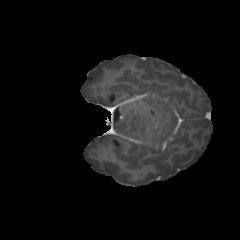

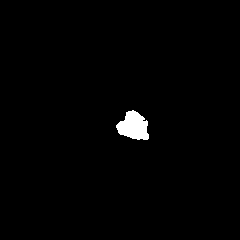

In [ ]:
# Display results for validation image #10
i = 200

# # Display input image
display(Image(filename=test_image[i])) # test_image is a list

# # Display ground-truth target mask
img = ImageOps.autocontrast(load_img(test_mask[i])) # test_mask is also a list
display(img)

# # Display mask predicted by our model
# display_mask(i)  # Note that the model only sees inputs at 150x150.

og_img = cv.imread(test_image[i])
mask_img = cv.imread(test_mask[i])

multiplied = og_img*mask_img

cv.imshow("multiplied", multiplied)
# waits for user to press any key
# (this is necessary to avoid Python kernel form crashing)
cv.waitKey(0)

# closing all open windows
cv.destroyAllWindows()


In [ ]:
# Add this after loading a batch
for images, masks in train_dataset.take(5):
    print("Images shape:", images.shape)
    print("Images min/max:", tf.reduce_min(images), tf.reduce_max(images))
    print("Masks shape:", masks.shape)
    print("Unique mask values:", np.unique(masks))

Images shape: (16, 240, 240, 1)
Images min/max: tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Masks shape: (16, 240, 240, 1)
Unique mask values: [0.]
Images shape: (16, 240, 240, 1)
Images min/max: tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Masks shape: (16, 240, 240, 1)
Unique mask values: [0.]
Images shape: (16, 240, 240, 1)
Images min/max: tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Masks shape: (16, 240, 240, 1)
Unique mask values: [0.]
Images shape: (16, 240, 240, 1)
Images min/max: tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Masks shape: (16, 240, 240, 1)
Unique mask values: [0.]
Images shape: (16, 240, 240, 1)
Images min/max: tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Masks shape: (16, 240, 240, 1)
Unique mask values: [0.]


2025-02-16 20:06:05.327160: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
